In [1]:
# Jupyter notebook for evaluating formula assignment criteria of LC-21T-FTICRMS data using CoreMS
# RMB update 1/12/2023
# Contributors: Yuri Corilo, Will Kew, Christian Dewey, Rene Boiteau

##########

# Import the os module
import os
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("./")
from pathlib import Path

# Change the current working directory
os.chdir('../..')

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data'
file="RMB_190828_BATSpooled_30" #pooled sample for formula assignments
bfile="RMB_190828_BATS24_blnk" #blank sample

# Import required modules
import matplotlib.pyplot as plt
from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration
import matplotlib.backends.backend_pdf

#Set peak detection threshold method
refmasslist = Path.cwd() / "tests/tests_data/ftms/Seawater_NOM_pos.ref"
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.25
MSParameters.molecular_search.max_ppm_error = 0.25

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

#Read in sample list and load MS data
MSfiles={}

parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
bparser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+bfile)

MSfiles[file]=parser


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


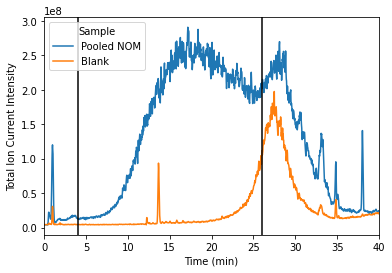

In [2]:
#Plot total ion chromatograms to evaluate useful time range. 

tic=parser.get_tic(ms_type='MS')[0]
btic=bparser.get_tic(ms_type='MS')[0]

#tic_df=pd.DataFrame({'Time': tic.time,'Intensity': tic.tic,'Sample':'Pooled NOM'})
tic_df=pd.DataFrame({'Time': tic.time,'Intensity': tic.tic,'Sample':'Pooled NOM'})
btic_df=pd.DataFrame({'Time': btic.time,'Intensity': btic.tic,'Sample':'Blank'})

tic_df=pd.concat([tic_df,btic_df])
tic_df=tic_df.reset_index()

fig, (ax) = plt.subplots(1)
sns.lineplot(x='Time',y='Intensity',data=tic_df,ax=ax, hue='Sample')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Total Ion Current Intensity')
ax.set_xlim(0,40)
ax.axvline(x=4,color='black')
ax.axvline(x=26,color='black')
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.savefig(file_location+'CoreLCMS_FigS1.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS1.pdf',dpi=300,format='pdf')



In [3]:
#Function to build formula assignment lists
interval=2
timerange=[4,26]

B=21 #magnetic field strength
T=0.6 #transient time

def lcmsformula(parser,interval,timerange):
    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        #Now, get an average mass spectrum and list the centroided m/z values of the spectrum. One of these should be the molecule of interest.
        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)
        mass_spectrum.filter_by_min_resolving_power(B, T)
    
        mass_spectrum.settings.min_calib_ppm_error = 2
        mass_spectrum.settings.max_calib_ppm_error = -2

        calfn = MzDomainCalibration(mass_spectrum, refmasslist)
        ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

        imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=(-2.0, 2.0),
                                                    calib_snr_threshold=4)

        calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)

In [10]:
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 20

#First, evaluate wide attribution criteria
MSParameters.molecular_search.usedAtoms['C'] = (4,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,8)
MSParameters.molecular_search.usedAtoms['S'] = (0,2)
MSParameters.molecular_search.usedAtoms['P'] = (0,1)
MSParameters.molecular_search.usedAtoms['Na'] = (0,1)


#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_df=pd.concat(masterresults.values())
masterresults_df.to_csv(file_location+'pooled_results_wide.csv')

RMB_190828_BATSpooled_30
MS Obj loaded - 449 peaks found.
MS Obj loaded - 449 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 856 fn evals and 20 iterations


100%|██████████| 548/548 [00:01<00:00, 458.34it/s]


Started database insert using 14546 iterations for a total of 727281 rows


14546it [06:40, 36.30it/s]


'runworker'  405051.53 ms


Loading molecular formula database: 232291it [00:17, 13343.19it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 116.41it/s]
Loading molecular formula database: 235756it [00:18, 12906.85it/s]
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 106.76it/s]
Loading molecular formula database: 237195it [00:18, 12933.66it/s]
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 133.13it/s]
Loading molecular formula database: 235722it [00:16, 13972.18it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 136.64it/s]
Loading molecular formula database: 236193it [00:20, 11544.45it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  554627.42 ms
427 assigned peaks and 22 unassigned peaks, total  = 95.10 %, relative abundance = 88.05 %, RMS error (best candidate) (ppm) = 0.069
MS Obj loaded - 685 peaks found.
MS Obj loaded - 685 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
302 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 860 fn evals and 20 iterations
'runworker'  1022.60 ms


Loading molecular formula database: 232291it [00:18, 12860.33it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 86.25it/s] 
Loading molecular formula database: 235756it [00:19, 12060.01it/s]
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 92.53it/s] 
Loading molecular formula database: 237195it [00:18, 12556.36it/s]
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:02<00:00, 105.89it/s]
Loading molecular formula database: 235722it [00:21, 10958.36it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 91.67it/s] 
Loading molecular formula database: 236193it [00:19, 12188.27it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  166313.25 ms
662 assigned peaks and 23 unassigned peaks, total  = 96.64 %, relative abundance = 93.08 %, RMS error (best candidate) (ppm) = 0.068
MS Obj loaded - 812 peaks found.
MS Obj loaded - 812 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
369 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  1578.58 ms


Loading molecular formula database: 232291it [00:19, 11679.13it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 81.08it/s] 
Loading molecular formula database: 235756it [00:21, 10745.15it/s]
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 82.44it/s] 
Loading molecular formula database: 237195it [00:20, 11356.05it/s]
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 88.08it/s] 
Loading molecular formula database: 235722it [00:18, 12978.73it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 67.75it/s]
Loading molecular formula database: 236193it [00:22, 10689.58it/s]
Started molecular formula search for class {"N"

'run_molecular_formula'  175627.71 ms
796 assigned peaks and 16 unassigned peaks, total  = 98.03 %, relative abundance = 97.27 %, RMS error (best candidate) (ppm) = 0.068
MS Obj loaded - 941 peaks found.
MS Obj loaded - 941 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
446 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3005 fn evals and 69 iterations
'runworker'  1103.23 ms


Loading molecular formula database: 232291it [00:18, 12360.53it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 85.24it/s] 
Loading molecular formula database: 235756it [00:21, 10972.76it/s]
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 83.75it/s] 
Loading molecular formula database: 237195it [00:20, 11659.47it/s]
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 93.11it/s] 
Loading molecular formula database: 235722it [00:17, 13229.88it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 89.46it/s] 
Loading molecular formula database: 236193it [00:22, 10700.19it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  176847.84 ms
926 assigned peaks and 15 unassigned peaks, total  = 98.41 %, relative abundance = 98.68 %, RMS error (best candidate) (ppm) = 0.065
MS Obj loaded - 1041 peaks found.
MS Obj loaded - 1041 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
479 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3036 fn evals and 67 iterations
'runworker'  1426.54 ms


Loading molecular formula database: 232291it [00:18, 12477.77it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 72.89it/s] 
Loading molecular formula database: 235756it [00:26, 9004.55it/s] 
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 72.88it/s] 
Loading molecular formula database: 237195it [00:19, 12096.12it/s]
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 87.98it/s] 
Loading molecular formula database: 235722it [00:22, 10644.27it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 89.26it/s] 
Loading molecular formula database: 236193it [00:19, 12414.67it/s]
Started molecular formula search for class {"N

'run_molecular_formula'  179166.16 ms
1025 assigned peaks and 16 unassigned peaks, total  = 98.46 %, relative abundance = 97.92 %, RMS error (best candidate) (ppm) = 0.069
MS Obj loaded - 1047 peaks found.
MS Obj loaded - 1047 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
485 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  1077.62 ms


Loading molecular formula database: 232291it [00:22, 10207.63it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 67.63it/s] 
Loading molecular formula database: 235756it [00:26, 8920.28it/s] 
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 62.74it/s]
Loading molecular formula database: 237195it [00:26, 8947.12it/s] 
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:09<00:00, 32.41it/s]
Loading molecular formula database: 235722it [00:36, 6461.85it/s] 
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 58.25it/s]
Loading molecular formula database: 236193it [00:27, 8523.47it/s] 
Started molecular formula search for class {"N": 

'run_molecular_formula'  226267.00 ms
1033 assigned peaks and 14 unassigned peaks, total  = 98.66 %, relative abundance = 97.82 %, RMS error (best candidate) (ppm) = 0.069
MS Obj loaded - 1128 peaks found.
MS Obj loaded - 1128 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
479 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  1025.12 ms


Loading molecular formula database: 232291it [00:18, 12515.50it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 71.53it/s]
Loading molecular formula database: 235756it [00:23, 10127.20it/s]
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 67.01it/s]
Loading molecular formula database: 237195it [00:20, 11522.33it/s]
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 80.61it/s] 
Loading molecular formula database: 235722it [00:23, 10232.51it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 74.55it/s]
Loading molecular formula database: 236193it [00:21, 11071.35it/s]
Started molecular formula search for class {"N": 

'run_molecular_formula'  185990.97 ms
1113 assigned peaks and 15 unassigned peaks, total  = 98.67 %, relative abundance = 97.56 %, RMS error (best candidate) (ppm) = 0.068
MS Obj loaded - 1413 peaks found.
MS Obj loaded - 1413 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
542 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 465 fn evals and 10 iterations
'runworker'  1630.01 ms


Loading molecular formula database: 232291it [00:28, 8137.87it/s] 
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 54.79it/s]
Loading molecular formula database: 235756it [00:20, 11408.11it/s]
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 59.29it/s]
Loading molecular formula database: 237195it [00:24, 9615.85it/s] 
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 54.74it/s]
Loading molecular formula database: 235722it [00:22, 10458.30it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 67.18it/s]
Loading molecular formula database: 236193it [00:21, 11239.13it/s]
Started molecular formula search for class {"N": 6

'run_molecular_formula'  206626.71 ms
1389 assigned peaks and 24 unassigned peaks, total  = 98.30 %, relative abundance = 98.33 %, RMS error (best candidate) (ppm) = 0.078
MS Obj loaded - 1349 peaks found.
MS Obj loaded - 1349 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
470 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 472 fn evals and 10 iterations
'runworker'  1246.04 ms


Loading molecular formula database: 232291it [00:22, 10554.08it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 59.34it/s]
Loading molecular formula database: 235756it [00:22, 10592.11it/s]
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 59.11it/s]
Loading molecular formula database: 237195it [00:25, 9287.93it/s] 
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 67.35it/s]
Loading molecular formula database: 235722it [00:22, 10527.16it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 68.98it/s]
Loading molecular formula database: 236193it [00:24, 9590.55it/s] 
Started molecular formula search for class {"N": 6

'run_molecular_formula'  211337.48 ms
1322 assigned peaks and 27 unassigned peaks, total  = 98.00 %, relative abundance = 96.84 %, RMS error (best candidate) (ppm) = 0.070
MS Obj loaded - 1298 peaks found.
MS Obj loaded - 1298 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
352 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.035 ppm
minimize function performed 3037 fn evals and 71 iterations
'runworker'  1526.36 ms


Loading molecular formula database: 232291it [00:22, 10363.30it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 53.43it/s]
Loading molecular formula database: 235756it [00:24, 9471.52it/s] 
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 60.77it/s]
Loading molecular formula database: 237195it [00:23, 10258.79it/s]
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 69.79it/s]
Loading molecular formula database: 235722it [00:23, 10147.73it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 74.51it/s] 
Loading molecular formula database: 236193it [00:21, 11219.34it/s]
Started molecular formula search for class {"N": 

'run_molecular_formula'  200136.96 ms
1254 assigned peaks and 44 unassigned peaks, total  = 96.61 %, relative abundance = 96.07 %, RMS error (best candidate) (ppm) = 0.065
MS Obj loaded - 1147 peaks found.
MS Obj loaded - 1147 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
208 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 3039 fn evals and 69 iterations
'runworker'  1017.82 ms


Loading molecular formula database: 232291it [00:18, 12755.31it/s]
Started molecular formula search for class {"N": 1, "S": 2, "P": 1, "O": 5, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 64.42it/s]
Loading molecular formula database: 235756it [00:24, 9803.47it/s] 
Started molecular formula search for class {"N": 2, "S": 2, "P": 1, "O": 10, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:04<00:00, 65.73it/s]
Loading molecular formula database: 237195it [00:25, 9397.00it/s] 
Started molecular formula search for class {"N": 3, "S": 2, "P": 1, "O": 15, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 77.59it/s] 
Loading molecular formula database: 235722it [00:22, 10498.18it/s]
Started molecular formula search for class {"N": 4, "S": 2, "P": 1, "O": 20, "Na": 1}, (de)protonated : 100%|██████████| 300/300 [00:03<00:00, 81.14it/s] 
Loading molecular formula database: 236193it [00:20, 11654.12it/s]
Started molecular formula search for class {"N":

'run_molecular_formula'  192275.15 ms
1112 assigned peaks and 35 unassigned peaks, total  = 96.95 %, relative abundance = 97.31 %, RMS error (best candidate) (ppm) = 0.065


Unique molecular formula #: 3523
Unique m/z peaks: 3433
All assignments: 9710
Good assignments: 9202
Questionable assignments: 508


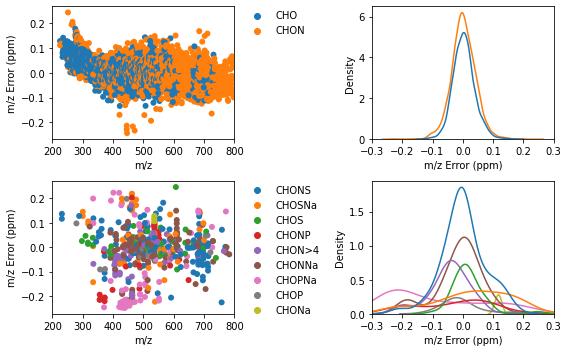

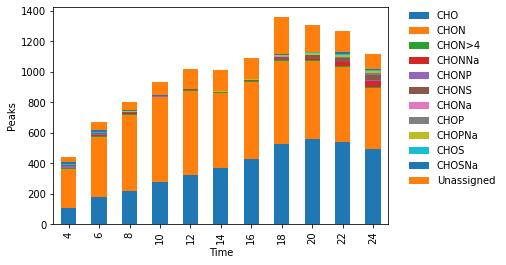

In [16]:
# Plot clean results. 

allresults=masterresults_df[(masterresults_df['m/z']<800)]

allresults['N']=allresults['N'].fillna(0)
allresults['O']=allresults['O'].fillna(0)
allresults['S']=allresults['S'].fillna(0)
allresults['P']=allresults['P'].fillna(0)
allresults['Na']=allresults['Na'].fillna(0)

allresults['Molecular class']='Unassigned'
allresults['Molecular class'][allresults['C']>0]='CHO'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>4.5)]='CHON>4'
allresults['Molecular class'][(allresults['C']>0) & (allresults['P']>0.5)]='CHOP'
allresults['Molecular class'][(allresults['C']>0) & (allresults['Na']>0.5)]='CHONa'
allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5)]='CHOS'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5)]='CHONS'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['P']>0.5)]='CHONP'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['P']>0.5)]='CHOSP'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['Na']>0.5)]='CHONNa'
allresults['Molecular class'][(allresults['C']>0) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHOPNa'
allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['Na']>0.5)]='CHOSNa'
allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5) & (allresults['P']>0.5)]='Unassigned'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['S']>0.5) & (allresults['Na']>0.5)]='CHONSNa'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['N']>0.5) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHONPNa'
#allresults['Molecular class'][(allresults['C']>0) & (allresults['S']>0.5) & (allresults['P']>0.5) & (allresults['Na']>0.5)]='CHONSNa'

results=allresults[allresults['Is Isotopologue']==0]
results=allresults[allresults['Molecular class']!='Unassigned']

results_1=results[(results['Molecular class'].isin(['CHO','CHON']))]
results_2=results[(~results['Molecular class'].isin(['CHO','CHON']))]

#results_2=results[(results['Molecular class']!='CHO') | (results['Molecular class']!='CHON<4')]


Assignedlist=masterresults_df[(masterresults_df['m/z']<800)]
print('Unique molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))

print('All assignments:', len(results))
print('Good assignments:', len(results_1))
print('Questionable assignments:', len(results_2))




fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(8, 5)


sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='Molecular class',data=results_1,ax=ax1, edgecolor='none')
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
ax1.set_xlim(200,800)
sns.kdeplot(x='m/z Error (ppm)',data=results_1,hue='Molecular class',ax=ax2,legend=False)
ax2.set_xlim(-0.3,0.3)
fig.tight_layout()


sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='Molecular class',data=results_2,ax=ax3, edgecolor='none')
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
ax3.set_xlim(200,800)
sns.kdeplot(x='m/z Error (ppm)',data=results_2,hue='Molecular class',ax=ax4,legend=False)
ax4.set_xlim(-0.3,0.3)
fig.tight_layout()

fig.savefig(file_location+'CoreLCMS_FigS3.eps',dpi=300,format='eps')
fig.savefig(file_location+'CoreLCMS_FigS3.pdf',dpi=300,format='pdf')

assign_summary=[]

for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['Molecular class'].unique()):
        current[mol_class]=len(allresults[(allresults['Molecular class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)
df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)



plt.show()

In [8]:
#Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 20

#Second, evaluate narrow attribution criteria
MSParameters.molecular_search.usedAtoms['C'] = (4,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,4)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)
MSParameters.molecular_search.usedAtoms['P'] = (0,0)
MSParameters.molecular_search.usedAtoms['Na'] = (0,0)

Heteroatoms=['N']

#MSpeak highest confidence molecular formula. 

#### Core feature extraction function.
masterresults={}

for file in MSfiles:
    print(file)
    results=lcmsformula(MSfiles[file],interval,timerange)
    results['File']=file
    masterresults[file]=results

#This will create masterresults_df from above masterresults and save
masterresults_2_df=pd.concat(masterresults.values())
masterresults_2_df.to_csv(file_location+'pooled_results_narrow.csv')

RMB_190828_BATSpooled_30
MS Obj loaded - 449 peaks found.
MS Obj loaded - 449 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
167 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.026 ppm
minimize function performed 856 fn evals and 20 iterations
'runworker'  1514.39 ms


Loading molecular formula database: 125378it [00:08, 15525.20it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:01<00:00, 132.08it/s]


'run_molecular_formula'  10820.91 ms
371 assigned peaks and 78 unassigned peaks, total  = 82.63 %, relative abundance = 69.54 %, RMS error (best candidate) (ppm) = 0.043
MS Obj loaded - 685 peaks found.
MS Obj loaded - 685 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
302 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.030 ppm
minimize function performed 860 fn evals and 20 iterations
'runworker'  1357.63 ms


Loading molecular formula database: 125378it [00:08, 15497.94it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:01<00:00, 99.26it/s] 


'run_molecular_formula'  11064.92 ms
613 assigned peaks and 72 unassigned peaks, total  = 89.49 %, relative abundance = 82.74 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 812 peaks found.
MS Obj loaded - 812 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
369 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.039 ppm
minimize function performed 322 fn evals and 6 iterations
'runworker'  1198.99 ms


Loading molecular formula database: 125378it [00:08, 15350.60it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:01<00:00, 90.47it/s] 


'run_molecular_formula'  11133.92 ms
765 assigned peaks and 47 unassigned peaks, total  = 94.21 %, relative abundance = 93.24 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 941 peaks found.
MS Obj loaded - 941 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
446 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.028 ppm
minimize function performed 3005 fn evals and 69 iterations
'runworker'  1450.36 ms


Loading molecular formula database: 125378it [00:08, 14868.99it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:01<00:00, 81.88it/s] 


'run_molecular_formula'  11825.86 ms
913 assigned peaks and 28 unassigned peaks, total  = 97.02 %, relative abundance = 97.80 %, RMS error (best candidate) (ppm) = 0.041
MS Obj loaded - 1041 peaks found.
MS Obj loaded - 1041 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
479 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.027 ppm
minimize function performed 3036 fn evals and 67 iterations
'runworker'  1327.06 ms


Loading molecular formula database: 125378it [00:09, 13844.48it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 68.56it/s]


'run_molecular_formula'  12699.61 ms
1005 assigned peaks and 36 unassigned peaks, total  = 96.54 %, relative abundance = 96.99 %, RMS error (best candidate) (ppm) = 0.047
MS Obj loaded - 1047 peaks found.
MS Obj loaded - 1047 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
485 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  1478.75 ms


Loading molecular formula database: 125378it [00:09, 13582.54it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 71.48it/s]


'run_molecular_formula'  12944.20 ms
1010 assigned peaks and 37 unassigned peaks, total  = 96.47 %, relative abundance = 96.58 %, RMS error (best candidate) (ppm) = 0.055
MS Obj loaded - 1128 peaks found.
MS Obj loaded - 1128 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
479 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.029 ppm
minimize function performed 470 fn evals and 10 iterations
'runworker'  1408.58 ms


Loading molecular formula database: 125378it [00:10, 12330.13it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 64.28it/s]


'run_molecular_formula'  14056.15 ms
1094 assigned peaks and 34 unassigned peaks, total  = 96.99 %, relative abundance = 95.86 %, RMS error (best candidate) (ppm) = 0.050
MS Obj loaded - 1413 peaks found.
MS Obj loaded - 1413 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
542 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.032 ppm
minimize function performed 465 fn evals and 10 iterations
'runworker'  598.78 ms


Loading molecular formula database: 125378it [00:10, 11641.62it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 53.41it/s]


'run_molecular_formula'  14328.14 ms
1335 assigned peaks and 78 unassigned peaks, total  = 94.48 %, relative abundance = 95.92 %, RMS error (best candidate) (ppm) = 0.050
MS Obj loaded - 1349 peaks found.
MS Obj loaded - 1349 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
470 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.034 ppm
minimize function performed 472 fn evals and 10 iterations
'runworker'  906.35 ms


Loading molecular formula database: 125378it [00:10, 11977.50it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 55.42it/s]


'run_molecular_formula'  14246.68 ms
1263 assigned peaks and 86 unassigned peaks, total  = 93.62 %, relative abundance = 93.84 %, RMS error (best candidate) (ppm) = 0.048
MS Obj loaded - 1298 peaks found.
MS Obj loaded - 1298 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
352 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.035 ppm
minimize function performed 3037 fn evals and 71 iterations
'runworker'  1403.16 ms


Loading molecular formula database: 125378it [00:09, 12656.99it/s]
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:02<00:00, 58.85it/s]


'run_molecular_formula'  14017.06 ms
1163 assigned peaks and 135 unassigned peaks, total  = 89.60 %, relative abundance = 88.22 %, RMS error (best candidate) (ppm) = 0.042
MS Obj loaded - 1147 peaks found.
MS Obj loaded - 1147 peaks found.
Reference mass list loaded - 1007 calibration masses loaded.
208 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.040 ppm
minimize function performed 3039 fn evals and 69 iterations
'runworker'  1432.45 ms


Loading molecular formula database: 125378it [00:13, 9569.56it/s] 
Started molecular formula search for class {"N": 4, "O": 30}, (de)protonated : 100%|██████████| 150/150 [00:04<00:00, 35.79it/s]


'run_molecular_formula'  18989.29 ms
991 assigned peaks and 156 unassigned peaks, total  = 86.40 %, relative abundance = 90.18 %, RMS error (best candidate) (ppm) = 0.050


Average Total: 11309.0
Unique  molecular formula #: 3218
Unique good molecular formula #: 3031
Unique m/z peaks: 3433


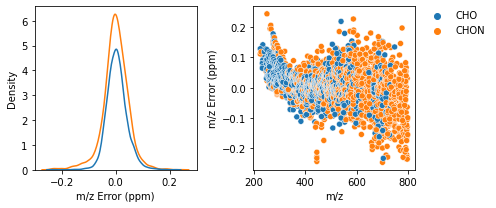

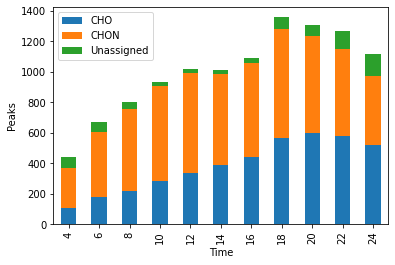

In [9]:
# Plot formula assignment details
allresults=masterresults_2_df[(masterresults_2_df['m/z']<800) & (masterresults_2_df['S/N']>2)]

allresults['O']=allresults['O'].fillna(0)

for element in Heteroatoms:
    allresults[element]=allresults[element].fillna(0)

allresults['mol_class']='Unassigned'
allresults['mol_class'][allresults['C']>0]='CHO'
allresults['mol_class'][(allresults['C']>0) & (allresults['N']>0.5)]='CHON'

results=allresults[allresults['Is Isotopologue']==0]


print('Average Total:', len(masterresults_df)/len(MSfiles))
print('Unique  molecular formula #:', len(masterresults_df['Molecular Formula'].unique()))
Assignedlist=masterresults_df[(masterresults_df['m/z']<800)]
print('Unique good molecular formula #:', len(Assignedlist['Molecular Formula'].unique()))
print('Unique m/z peaks:', len(masterresults_df['m/z'].round(3).unique()))


fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(7, 3)

sns.kdeplot(x='m/z Error (ppm)',data=results,hue='mol_class',ax=ax1,legend=False)
ax1.set_xlim(-0.3,0.3)
sns.scatterplot(x='m/z',y='m/z Error (ppm)',hue='mol_class',data=results,ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
fig.tight_layout()


assign_summary=[]

for time in allresults['Time'].unique():
    current={}
    current['Time']=time
    for mol_class in sorted(allresults['mol_class'].unique()):
        current[mol_class]=len(allresults[(allresults['mol_class']==mol_class) & (allresults['Time']==time)])
    assign_summary.append(current)
    #mzdiff=result['m/z'].sort_values(ascending=True).diff().iloc[1:]/result['m/z'].sort_values(ascending=True).iloc[1:]*1E6


df=pd.DataFrame(assign_summary)

df.plot.bar(x='Time',y=df.columns[1:],stacked=True,ylabel='Peaks')


plt.show()
